In [1]:
# --- Cell 1: Imports ---
# All necessary imports, consolidated for clarity and organization.

import os
import sys
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import slic
from skimage.color import label2rgb
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, vit_b_16, ViT_B_16_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import wandb  # For experiment tracking
import optuna  # For hyperparameter optimization (used later)

import albumentations as A  # For image augmentations
from albumentations.pytorch import ToTensorV2

from pytorch_grad_cam import GradCAM  # For Grad-CAM (used later)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
# --- Cell 2: GPU Check ---
# Verify that CUDA (GPU support) is available and accessible.

import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA L4


In [3]:
# --- Cell 3: Weights & Biases Initialization ---
# Initialize a new W&B run for experiment tracking.  Best to do this early.

run = wandb.init(project="vit", entity="w2sgarnav", name="w2sgarnav-vit", mode="offline")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [5]:
# --- Cell 4: Configuration ---
# Define constants and hyperparameters for the project.

DATASET_ROOT = "/teamspace/studios/this_studio/8-phases/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection"  # YOUR DATASET PATH
ORIGINAL_DIR = os.path.join(DATASET_ROOT, "Original Dataset")
AUGMENTED_DIR = os.path.join(DATASET_ROOT, "Augmented Dataset")  # Use if you have augmentations

CLASSES = [
    "Bacterial Blight",
    "Curl Virus",
    "Healthy Leaf",
    "Herbicide Growth Damage",
    "Leaf Hopper Jassids",
    "Leaf Redding",
    "Leaf Variegation",
]
NUM_CLASSES = len(CLASSES)
CLASS_MAP = {i: name for i, name in enumerate(CLASSES)}  # Mapping: index -> class name

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 30
NUM_WORKERS = 6
VAL_SIZE = 0.2
TEST_SIZE = 0.2
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# --- Cell 5: Custom Dataset Class (CottonLeafDataset) ---
# Defines the custom dataset for loading cotton leaf images.

class CottonLeafDataset(Dataset):
    def __init__(self, data_dir, transform=None, class_names=CLASSES):
        self.data_dir = data_dir
        self.transform = transform
        self.class_names = class_names
        self.image_paths, self.labels = self._load_data()

    def _load_data(self):
        image_paths = []
        labels = []
        for i, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.data_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: Directory not found: {class_dir}")
                continue

            for image_path in glob.glob(os.path.join(class_dir, "*.jpg")) + glob.glob(
                os.path.join(class_dir, "*.jpeg")) + glob.glob(os.path.join(class_dir, "*.png")):
                image_paths.append(image_path)
                labels.append(i)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except (IOError, FileNotFoundError) as e:
            print(f"Error loading image: {image_path} - {e}. Returning a blank image.")
            return torch.zeros((3, *IMAGE_SIZE)), torch.tensor(0)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)  # Ensure label is a tensor

In [7]:
# --- Cell 6: Data Splitting Function ---
# Creates stratified train/validation/test splits.

def create_data_splits(data_dir, val_size=0.2, test_size=0.2, random_state=42):
    image_files, labels = [], []
    for i, class_name in enumerate(CLASSES):
        class_path = os.path.join(data_dir, class_name)
        for file_path in glob.glob(os.path.join(class_path, "*")):
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(file_path)
                labels.append(i)

    train_files, temp_files, train_labels, temp_labels = train_test_split(
        image_files, labels, test_size=(val_size + test_size), random_state=random_state, stratify=labels
    )
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=(test_size / (val_size + test_size)), random_state=random_state, stratify=temp_labels
    )
    return train_files, val_files, test_files, train_labels, val_labels, test_labels

In [8]:
# --- Cell 7: Data Augmentation Transforms (Albumentations) ---
# Defines data augmentation and preprocessing transforms.

def get_transforms(image_size=IMAGE_SIZE, train=True):
    if train:
        return A.Compose([
            A.Resize(height=image_size[0], width=image_size[1]),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=image_size[0], width=image_size[1]),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

class PILTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.transform(image=img_np)
        return augmented['image']

In [9]:
# --- Cell 8: Image Preprocessing Functions --- (FINAL, ROBUST VERSION)
def segment_leaf(image):
    print(f"Segment leaf input type: {type(image)}")  # Debugging: Confirm input type
    image_np = np.array(image)
    print(f"Image array shape: {image_np.shape}, dtype: {image_np.dtype}")  # Debugging: Check the shape and dtype

    segments = slic(image_np, n_segments=100, compactness=10, sigma=1)
    leaf_segment_label = np.argmax(np.bincount(segments.ravel()))
    leaf_mask = (segments == leaf_segment_label).astype(np.uint8)

    # --- FIX: Check for Empty Mask *IMMEDIATELY* After SLIC ---
    if np.all(leaf_mask == 0):
        print("Mask is empty immediately after SLIC. Returning original image and blank mask.")
        return image, Image.fromarray(np.zeros(image_np.shape[:2], dtype=np.uint8))

    kernel = np.ones((5, 5), np.uint8)
    leaf_mask = cv2.dilate(leaf_mask, kernel, iterations=1)
    leaf_mask = cv2.erode(leaf_mask, kernel, iterations=1)

    if np.all(leaf_mask == 0):
        print("Mask is empty after dilation/erosion. Returning original image and blank mask.")
        return image, Image.fromarray(np.zeros(image_np.shape[:2], dtype=np.uint8))

    segmented_image_np = cv2.bitwise_and(image_np, image_np, mask=leaf_mask)
    segmented_image_np = segmented_image_np.astype(np.uint8)

    # Debugging: Check the shape and dtype of the segmented image and mask
    print(f"Segmented image shape: {segmented_image_np.shape}, dtype: {segmented_image_np.dtype}")
    print(f"Leaf mask shape: {leaf_mask.shape}, dtype: {leaf_mask.dtype}")

    # Ensure the image has the correct shape and data type
    if segmented_image_np.ndim == 2:
        segmented_image_np = np.stack([segmented_image_np] * 3, axis=-1)  # Convert grayscale to RGB
    elif segmented_image_np.shape[2] == 1:
        segmented_image_np = np.repeat(segmented_image_np, 3, axis=2)  # Convert single channel to RGB

    # Ensure the mask is in the correct shape
    if leaf_mask.ndim == 3:
        leaf_mask = leaf_mask.squeeze()  # Remove singleton dimensions

    # Debugging: Check the final shape and dtype before converting to PIL
    print(f"Final segmented image shape: {segmented_image_np.shape}, dtype: {segmented_image_np.dtype}")
    print(f"Final leaf mask shape: {leaf_mask.shape}, dtype: {leaf_mask.dtype}")

    return Image.fromarray(segmented_image_np), Image.fromarray(leaf_mask * 255)


def normalize_orientation(image, mask):
    image_np = np.array(image)
    mask_np = np.array(mask)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        min_area = 100
        if cv2.contourArea(largest_contour) < min_area:
            print("Contour area too small, skipping orientation normalization.")
            return image, mask
        if len(largest_contour) < 5:
            print("Contour has too few points, skipping orientation normalization.")
            return image, mask
        try:
            epsilon = 0.01 * cv2.arcLength(largest_contour, True)
            approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
            ellipse = cv2.fitEllipse(approx_contour)
            angle = ellipse[2]
            (h, w) = image_np.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_image = cv2.warpAffine(image_np, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC)
            rotated_mask = cv2.warpAffine(mask_np, rotation_matrix, (w, h), flags=cv2.INTER_NEAREST)
            return Image.fromarray(rotated_image), Image.fromarray(rotated_mask)
        except cv2.error as e:
            print(f"OpenCV error during orientation normalization: {e}")
            print("Skipping orientation normalization for this image.")
            return image, mask
    else:
        print("No contours found, skipping orientation normalization.")
        return image, mask
    return image, mask


def preprocess_image(image):
    print(f"Input image type: {type(image)}")  # Debugging: Check the type of the input
    if isinstance(image, torch.Tensor):
        print(f"Input image shape (Tensor): {image.shape}")  # Debugging: Check the shape if it's a tensor
        # Convert PyTorch tensor to NumPy array and transpose to (H, W, C)
        image_np = image.permute(1, 2, 0).numpy()  # Transpose from (C, H, W) to (H, W, C)
        image_np = (image_np * 255).astype(np.uint8)  # Convert to uint8 (PIL expects 0-255 range)
        image = Image.fromarray(image_np)  # Convert to PIL image
    elif isinstance(image, Image.Image):
        print(f"Input image size (PIL): {image.size}")  # Debugging: Check the size if it's a PIL image
    else:
        print(f"Input image type: {type(image)}")  # Debugging: Check the type if it's neither

    segmented_image, leaf_mask = segment_leaf(image)
    normalized_image, _ = normalize_orientation(segmented_image, leaf_mask)

    # Convert the final PIL image back to a tensor
    transform = transforms.ToTensor()  # Convert PIL image to tensor
    normalized_image_tensor = transform(normalized_image)  # Apply the transform
    return normalized_image_tensor

In [10]:
# --- Cell 9: Data Loader Creation ---
# Creates PyTorch DataLoaders for train, validation, and test sets.

def create_data_loaders(train_files, val_files, test_files, train_labels, val_labels, test_labels, train_transform, val_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_dataset = CottonLeafDataset(ORIGINAL_DIR, transform=train_transform)
    train_dataset.image_paths = train_files
    train_dataset.labels = train_labels

    val_dataset = CottonLeafDataset(ORIGINAL_DIR, transform=val_transform)
    val_dataset.image_paths = val_files
    val_dataset.labels = val_labels

    test_dataset = CottonLeafDataset(ORIGINAL_DIR, transform=val_transform)
    test_dataset.image_paths = test_files
    test_dataset.labels = test_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

In [11]:
# --- Cell 10: Data Visualization Function ---
# Displays sample images from a DataLoader.

def visualize_data(dataloader, num_images=5, title="Data Samples"):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(CLASSES[labels[i]])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

In [12]:
# --- Cell 11: Data Quality Assessment Function ---
# Analyzes class distribution and reports missing files.

def assess_data_quality(data_dir, class_map=CLASS_MAP):
    class_counts = {}
    all_files = []
    all_labels = []

    for class_index, class_name in class_map.items():
        class_dir = os.path.join(data_dir, class_name)
        image_files = []

        if not os.path.exists(class_dir):
            print(f"WARNING: Class directory not found: {class_dir}")
            class_counts[class_name] = 0
            continue

        for ext in ("*.jpg", "*.jpeg", "*.png"):
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))

        class_counts[class_name] = len(image_files)
        all_files.extend(image_files)
        all_labels.extend([class_name] * len(image_files))

    df = pd.DataFrame({"filepath": all_files, "label": all_labels})
    class_distribution = df['label'].value_counts().reset_index()
    class_distribution.columns = ['Class', 'Count']
    print("\nClass Distribution:")
    print(class_distribution)

    wandb.log({"class_distribution": wandb.Table(dataframe=class_distribution)})
    return df

In [13]:
# --- Cell 12: Save/Load Data Splits ---
# Functions to save and load the file paths of the data splits.

def save_data_splits(train_files, val_files, test_files, output_dir="."):
    os.makedirs(output_dir, exist_ok=True)
    def _write_list_to_file(file_list, filename):
        with open(os.path.join(output_dir, filename), "w") as f:
            for item in file_list:
                f.write(f"{item}\n")

    _write_list_to_file(train_files, "train_files.txt")
    _write_list_to_file(val_files, "val_files.txt")
    _write_list_to_file(test_files, "test_files.txt")
    print(f"Data splits saved to {output_dir}")

def load_data_splits(output_dir="."):
    def _read_list_from_file(filename):
        with open(os.path.join(output_dir, filename), "r") as f:
           return [line.strip() for line in f]
    train_files = _read_list_from_file("train_files.txt")
    val_files = _read_list_from_file("val_files.txt")
    test_files = _read_list_from_file("test_files.txt")

    return train_files, val_files, test_files

In [14]:
# --- Cell 13: Main Data Loading and Preprocessing Pipeline ---
# Combines all steps: data assessment, splitting, transforms, and loaders.

# 1. Assess data quality
data_quality_df = assess_data_quality(ORIGINAL_DIR, CLASS_MAP)

# 2. Create data splits
train_files, val_files, test_files, train_labels, val_labels, test_labels = create_data_splits(
    ORIGINAL_DIR, val_size=VAL_SIZE, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# 3. Save Splits
save_data_splits(train_files, val_files, test_files)

# Example of loading:  (You can comment this out if you're creating new splits)
# train_files, val_files, test_files = load_data_splits()

# 4. Get transforms
train_transforms = get_transforms(train=True)
val_transforms = get_transforms(train=False)

# 5. Apply preprocessing and combine with Albumentations.
train_transforms = transforms.Compose([
    PILTransform(train_transforms),
    transforms.Lambda(preprocess_image)
])
val_transforms = transforms.Compose([
    PILTransform(val_transforms),
    transforms.Lambda(preprocess_image)
])

# 6. Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_files, val_files, test_files, train_labels, val_labels, test_labels,
    train_transforms, val_transforms,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")


Class Distribution:
                     Class  Count
0             Leaf Redding    578
1               Curl Virus    431
2  Herbicide Growth Damage    280
3             Healthy Leaf    257
4         Bacterial Blight    250
5      Leaf Hopper Jassids    225
6         Leaf Variegation    116
Data splits saved to .
Number of training samples: 1282
Number of validation samples: 427
Number of test samples: 428


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Input image type: <class 'torch.Tensor'>Input image type: <class 'torch.Tensor'>Input image type: <class 'torch.Tensor'>Input image type: <class 'torch.Tensor'>Input image type: <class 'torch.Tensor'>Input image type: <class 'torch.Tensor'>





Input image shape (Tensor): torch.Size([3, 224, 224])Input image shape (Tensor): torch.Size([3, 224, 224])Input image shape (Tensor): torch.Size([3, 224, 224])Input image shape (Tensor): torch.Size([3, 224, 224])Input image shape (Tensor): torch.Size([3, 224, 224])Input image shape (Tensor): torch.Size([3, 224, 224])





Segment leaf input type: <class 'PIL.Image.Image'>Segment leaf input type: <class 'PIL.Image.Image'>Segment leaf input type: <class 'PIL.Image.Image'>Segment leaf input type: <class 'PIL.Image.Image'>Segment leaf input type: <class 'PIL.Image.Image'>Segment leaf input type: <class 'PIL.Image.Image'>





Image array shape: (224, 224, 3), dtype: uint8Image array shape: (224, 224, 3), dtype: uint8Image array shape: (224, 224, 3)


Input image shape (Tensor): torch.Size([3, 224, 224])
Segment leaf input type: <class 'PIL.Image.Image'>
Image array shape: (224, 224, 3), dtype: uint8
Segmented image shape: (224, 224, 3), dtype: uint8
Leaf mask shape: (224, 224), dtype: uint8
Final segmented image shape: (224, 224, 3), dtype: uint8
Segmented image shape: (224, 224, 3), dtype: uint8Final leaf mask shape: (224, 224), dtype: uint8

Leaf mask shape: (224, 224), dtype: uint8
Final segmented image shape: (224, 224, 3), dtype: uint8
Final leaf mask shape: (224, 224), dtype: uint8
Input image type: <class 'torch.Tensor'>Segmented image shape: (224, 224, 3), dtype: uint8

Leaf mask shape: (224, 224), dtype: uint8Input image shape (Tensor): torch.Size([3, 224, 224])

Final segmented image shape: (224, 224, 3), dtype: uint8Segmented image shape: (224, 224, 3), dtype: uint8
Segmented image shape: (224, 224, 3), dtype: uint8Segment leaf input type: <class 'PIL.Image.Image'>Final leaf mask shape: (224, 224), dtype: uint8



Leaf 

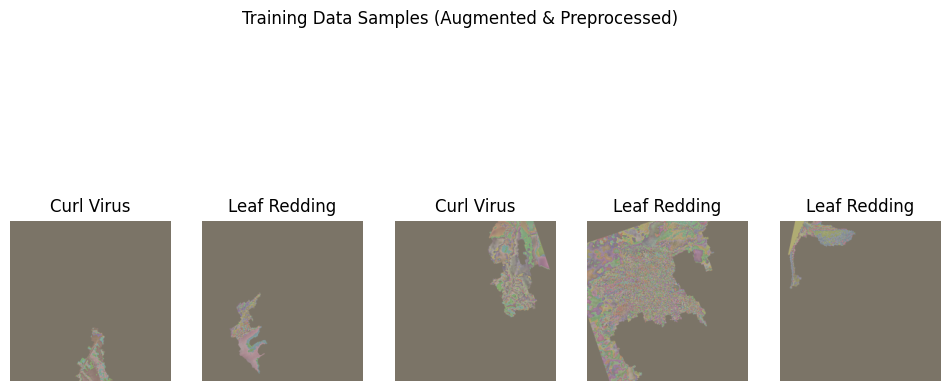






Final segmented image shape: (224, 224, 3), dtype: uint8
Final segmented image shape: (224, 224, 3), dtype: uint8Final segmented image shape: (224, 224, 3), dtype: uint8Final segmented image shape: (224, 224, 3), dtype: uint8Final segmented image shape: (224, 224, 3), dtype: uint8

Final segmented image shape: (224, 224, 3), dtype: uint8


Final leaf mask shape: (224, 224), dtype: uint8Final leaf mask shape: (224, 224), dtype: uint8
Final leaf mask shape: (224, 224), dtype: uint8Final leaf mask shape: (224, 224), dtype: uint8Final leaf mask shape: (224, 224), dtype: uint8


Final leaf mask shape: (224, 224), dtype: uint8


Input image type: <class 'torch.Tensor'>Input image type: <class 'torch.Tensor'>

Input image type: <class 'torch.Tensor'>Input image shape (Tensor): torch.Size([3, 224, 224])Input image shape (Tensor): torch.Size([3, 224, 224])


Input image type: <class 'torch.Tensor'>Input image shape (Tensor): torch.Size([3, 224, 224])Segment leaf input type: <class 'PIL.Ima

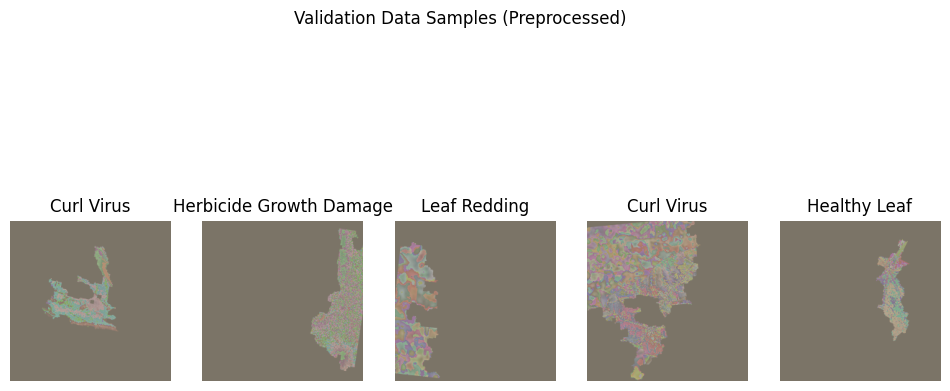

In [15]:
# --- Cell 14: Data Visualization ---
# Visualize sample images from the training and validation sets.

# Visualize training data
visualize_data(train_loader, title="Training Data Samples (Augmented & Preprocessed)")

# Visualize validation data
visualize_data(val_loader, title="Validation Data Samples (Preprocessed)")

In [16]:
# --- Cell 15: Finish W&B Run ---
wandb.finish()